# [E-14] 프로젝트: 폐렴 진단기 성능 개선

## 1. 실험 환경 set up

$ mkdir -p ~/aiffel/chest_xray
$ cd ~/Downloads && unzip archive.zip -d ~/aiffel

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [24]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 12

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [50, 50]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj23/aiffel


In [3]:
# 데이터 가져오기, 데이터 개수 확인

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))  # 데이터 모으기

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
 # 학습 데이터의 정상 이미지 수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

 # 학습 데이터의 폐렴 이미지 수
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1080
Pneumonia images count in training set: 3105


In [6]:
# tf.data 인스턴스 만들기: 배치처리 작업을 효율적으로 할 수 있게 해줌
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)  
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
 # 데이터 셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
# 라벨 이름 확인
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [9]:
# 라벨 데이터 만들기 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
# 이미지 사이즈 통일 및 사이즈 줄이기

def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):        # (1): 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (50, 50, 3)
Label:  True


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## 2. 데이터 준비하기

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)   # 고정 크기 버퍼 유지, 버퍼에서 무작위로 균일하게 다음 요소 선택

    ds = ds.repeat()             # epoch 진행 시 여러번 데이터셋을 사용할 수 있게 해줌

    ds = ds.batch(BATCH_SIZE)    # BATCH_SIZE로 정한만큼 배치로 주어짐

    ds = ds.prefetch(buffer_size=AUTOTUNE)        # 학습데이터 나눠서 읽으면서, 리소스 유휴 상태 줄임

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

> * 학습용 데이터를 시각화 해서 확인한다.
> * 만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인한다.

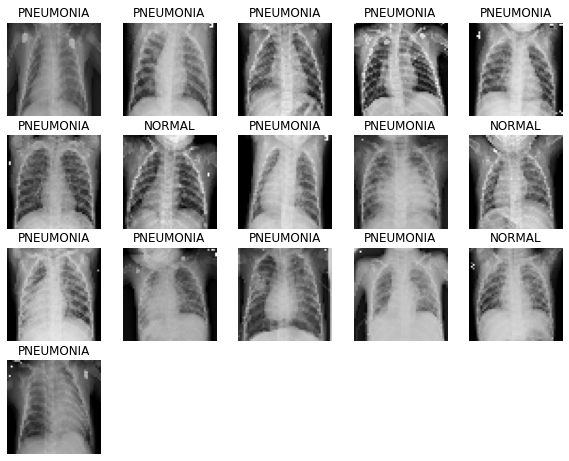

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

> * Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있다.
> * BatchNormalization과 Dropout 구성을 변경해 보면서 어떤 효과가 발생하는지 실험해 본다.
> * BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있다. Dropout 비율을 변경해볼 수도 있다.

In [16]:
def conv_block(filters):         
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()    
    ]
    )   # cov 두번 진행, batch normalization통해 grasident vanishing, gradient exploding 해결
        # Max Pooling
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

> * 실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 준다.

한 라벨이 너무 많은 경우를 **imbalance** 하다고 하는데, 데이터를 학습 할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.

이런 문제들을 해결하는 방법으로 **Weight balancing**이라는 테크닉이 사용된다. Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 **class_weight** 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고한다.

https://3months.tistory.com/414

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))    # 정상 이미지에 사용할 weight
print('Weight for class 1: {:.2f}'.format(weight_for_1))    # 폐렴 이미지에 사용할 weight

Weight for class 0: 1.94
Weight for class 1: 0.67


## 6. 모델 훈련

> * loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있다. 

In [20]:
with tf.device('/GPU:0'):     # GPU 사용 선택
    model = build_model()     # 위에서 만든 모델 함수 선언

    METRICS = [
        'accuracy',                                  # 정확도 측정
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',     # 이미지 라벨이 두 개, "binary_cross entropy" loss 사용
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
348/348 [==============================] - 29s 82ms/step - loss: 0.0894 - accuracy: 0.9700 - precision: 0.9911 - recall: 0.9684 - val_loss: 0.1089 - val_accuracy: 0.9648 - val_precision: 0.9930 - val_recall: 0.9597
Epoch 2/25
348/348 [==============================] - 29s 82ms/step - loss: 0.0934 - accuracy: 0.9650 - precision: 0.9908 - recall: 0.9619 - val_loss: 0.0777 - val_accuracy: 0.9734 - val_precision: 0.9808 - val_recall: 0.9836
Epoch 3/25
348/348 [==============================] - 30s 85ms/step - loss: 0.0856 - accuracy: 0.9693 - precision: 0.9913 - recall: 0.9669 - val_loss: 0.1623 - val_accuracy: 0.9511 - val_precision: 0.9486 - val_recall: 0.9873
Epoch 4/25
348/348 [==============================] - 30s 86ms/step - loss: 0.0940 - accuracy: 0.9616 - precision: 0.9895 - recall: 0.9584 - val_loss: 0.4285 - val_accuracy: 0.8958 - val_precision: 0.8782 - val_recall: 0.9971
Epoch 5/25
348/348 [==============================] - 29s 82ms/step - loss: 0.0870 - accuracy: 0

## 7. 결과 확인과 시각화

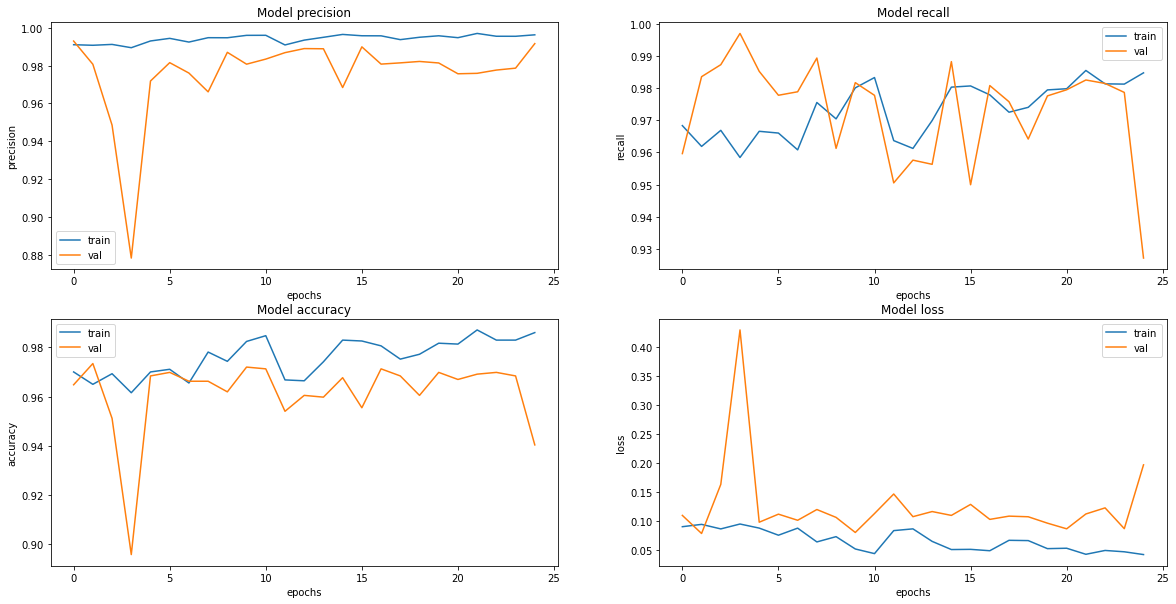

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 0.6477 - accuracy: 0.8606 - precision: 0.8359 - recall: 0.9667


## 결과

> 최종적으로 BATCH_SIZE = 12, 이미지 사이즈 = 50, 50으로 설정한 결과 정확도는 0.8606 가 나왔다.

## 총평

> 데이터에서 하나의 라벨이 너무 많은 경우를 imbalance하다 한다. imbalance 데이터는 데이터를 학습 할 때 학습 효과에 좋지 않은 영향을 미칠 수 있다. 이러한 문제는 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 **Weight balancing** 방법을 통해 해결하는 점이 흥미로웠다. 의료 데이터 이외에도 imbalance한 데이터셋에서 해당 방법을 적용해 보고 결과를 비교해보는 것은 좋은 시도일 듯 하다.